In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from json import load
from utils import project_points, heatmap2argmax
from scipy.spatial.transform import Rotation as R
import keras
import albumentations as A
from utils import produce_animation
from celluloid import Camera

plt.rcParams["figure.figsize"] = (10, 10)

FRAMES_DIR = "frames/"
IMG_SIZE = (256, 256)

In [2]:
camera_info = load(open("./reference/camera_info.json"))

model_view_matrix = np.array(camera_info['model_view_matrix'])
projection_matrix = np.array(camera_info['projection_matrix'], dtype = "double")

In [3]:
model = keras.models.load_model('result/unet_2Dheat.hdf5')

In [4]:
bounding_box_points_in_3d = np.float32(
    [(-0.156, -0.182, -0.032), 
     ( 0.156, -0.182, -0.032),
     (-0.156,  0.163, -0.032),
     ( 0.156,  0.163, -0.032),
     (-0.156, -0.182,  0.034),
     ( 0.156, -0.182,  0.034),
     (-0.156,  0.163,  0.034),
     ( 0.156,  0.163,  0.034)])

homogenious_bb_points = np.c_[bounding_box_points_in_3d, np.ones((8,1), dtype=np.float32)]
size = IMG_SIZE
distortion_coeffs = np.zeros((4,1))
focal_length = size[1]
center = (size[1]/2, size[0]/2)
matrix_camera = np.array(
                        [[focal_length, 0, center[0]],
                        [0, focal_length, center[1]],
                        [0, 0, -1]], dtype = "double"
                        )


In [5]:
frames = os.listdir(FRAMES_DIR)
frames.remove('.ipynb_checkpoints')
frames.remove('xwing.gif')
frames.remove('xwing.mp4')
frames[:3]

['000.jpg', '001.jpg', '002.jpg']

### If needed coords in camera coordinate frame. Below gif.

In [90]:
frames_camera_coords = []
for frame in frames:
    path = os.path.join(FRAMES_DIR, frame)
    img = cv2.imread(path)
    
    transformed_in = transform_in(image=img)
    in_img = transformed_in['image']

    pred = model.predict(np.expand_dims(in_img,axis=0))

    x = np.array(pred[0]).squeeze()
    y = np.array(pred[1]).squeeze()
    x_pix = []
    y_pix = []
    for i, j in zip(x, y):
        indx = np.argmax(i, axis=0)
        indy = np.argmax(j, axis=0)
        x_pix.append(indx)
        y_pix.append(indy)
        
    imagePoints = np.concatenate((np.array(x_pix).reshape(8,1), np.array(y_pix).reshape(8,1)),axis = 1)

    transformed_out = transform_out(image=in_img, keypoints=imagePoints)
    imagePoints = np.array(transformed_out['keypoints'])

    objectPoints = bounding_box_points_in_3d
    success, R_vec, t, inliers = cv2.solvePnPRansac(objectPoints, imagePoints, matrix_camera, distortion_coeffs)
    r = R.from_rotvec(R_vec.squeeze())
    extrinsic = np.concatenate((r.as_matrix(), t), axis=1)
    
    camera_coords = []
    for point in homogenious_bb_points:
        projected = extrinsic @ point
        camera_coords.append(projected)
        
    frames_camera_coords.append(camera_coords)
    

True


In [10]:
def heatmap2argmax(heatmap):
    index = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    y = index[0]
    x = index[1]
    index = x, y
    return np.array(index)

In [14]:
preds, images = [], []
for frame in frames:
    path = os.path.join(FRAMES_DIR, frame)
    img = cv2.cvtColor(
            cv2.imread(path), 
            cv2.COLOR_BGR2RGB
        )

    heatmaps = model.predict(np.expand_dims(img, axis=0))
    heatmaps = np.array(heatmaps).squeeze()
    heatmaps = heatmaps.reshape(heatmaps.shape[2], heatmaps.shape[0], heatmaps.shape[1])

    indmax, indexes = [], []
    for heatmap in heatmaps:
        indmax.append(heatmap2argmax(heatmap))
        
    #indexes.append(indmax)
    
    images.append(img), preds.append(indmax)
np.array(images).shape, np.array(preds).shape

((300, 256, 256, 3), (300, 8, 2))

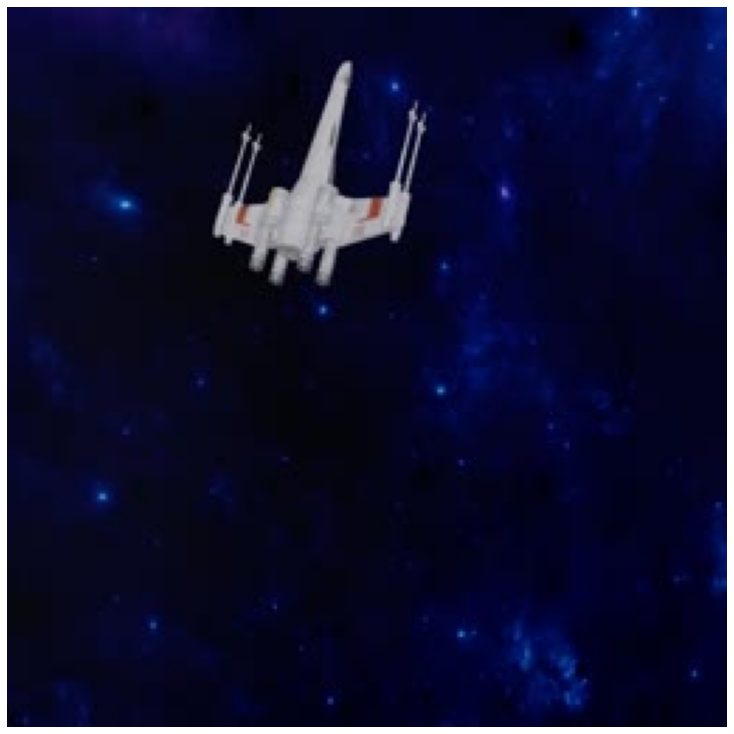

In [18]:
anim = produce_animation(np.array(images), np.array(preds, dtype=np.float32))

In [19]:
anim.save('anim.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.
